In [132]:
from src.functions import *

In [133]:
plt.rcParams.update(
    {
        "xtick.direction": "in",
        "ytick.direction": "out",
        "ytick.right": False,
        "xtick.top": False,
        "ytick.left": True,
        "xtick.bottom": False,
        "figure.facecolor": "1",
        "savefig.facecolor": "1",
        "savefig.dpi": 600,
        "figure.dpi": 600,
        "savefig.bbox": "tight",
        "font.size": 7,
        "font.family": "serif",
        "lines.markersize": 4,
        "lines.linewidth": 1,
        'axes.axisbelow' : True
    }
)

In [134]:
data = load_from_json(f'data/delta_vs_t.json')
delta_quantum_arr = np.asarray(data['delta'])
qubits_range = data['qubits_range']
time_range = data['time_range']
T = data['T']
gamma = data['gamma']

In [135]:
delta_quantum_arr_avg = np.mean(delta_quantum_arr, axis=2)
delta_quantum_arr_std = np.std(delta_quantum_arr, axis=2, ddof=1)

## $\delta$ vs $t$

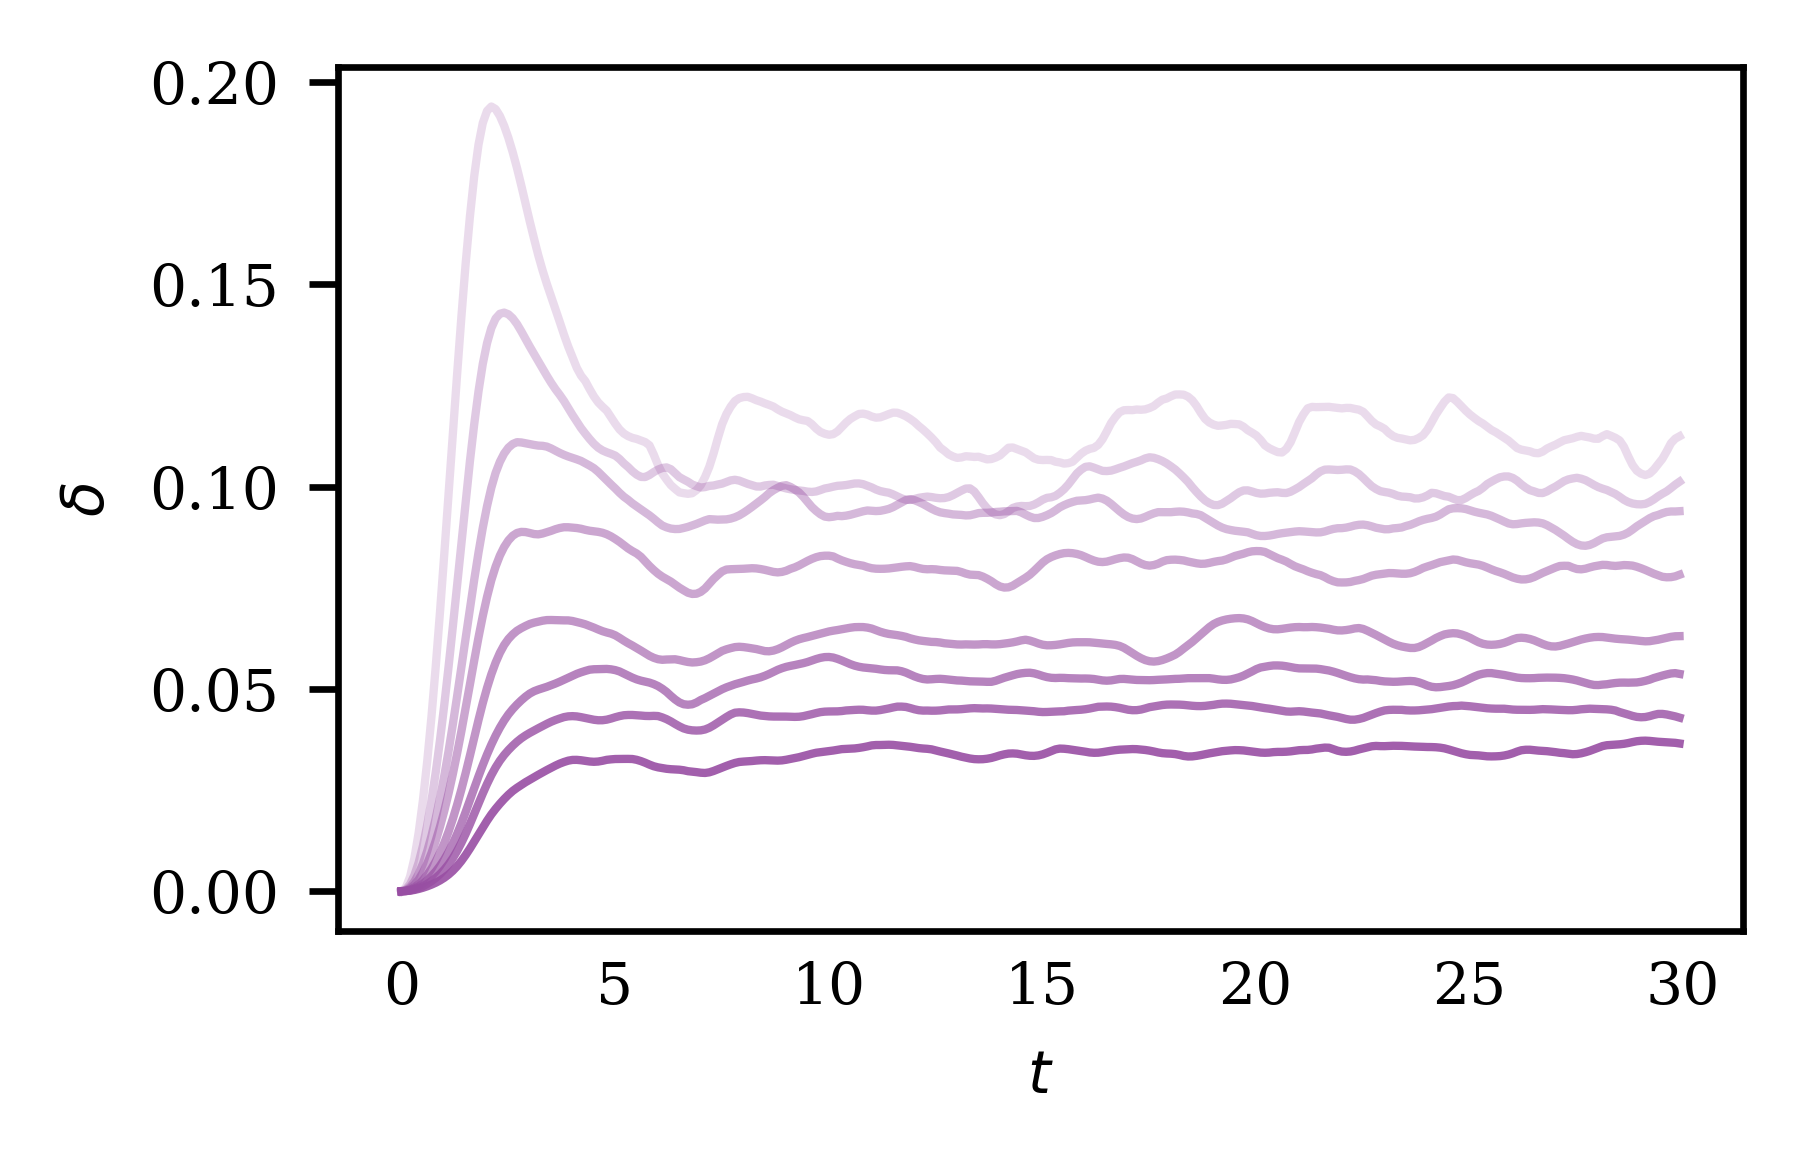

In [136]:
fig = plt.figure(figsize=(figure_size_x/2, figure_size_y/2))

for n_id, n in enumerate(qubits_range):
    plt.plot(time_range[:300], 
            delta_quantum_arr_avg[n_id][:300],
            color=colors['purple'],
            label=f'n={n}',
            alpha=(0.2 + 0.1*n_id))

plt.xlabel('$t$')
plt.ylabel('$\delta$')
# plt.legend()
plt.show()
fig.tight_layout()

fig.savefig(projectdir+f'figures/delta_vs_t')

## $\delta$ / $t$

In [137]:
arg_opt = np.asarray([np.argmin(np.divide(time_range, delta_quantum_arr_avg[n_id], out=np.ones_like(time_range, dtype=float)*np.inf, where=delta_quantum_arr_avg[n_id]!=0)) for n_id in range(len(qubits_range))])
t_opt_arr = np.asarray([time_range[i] for i in arg_opt])
delta_opt_arr = np.asarray([delta_quantum_arr_avg[i_id][i] for i_id, i in enumerate(arg_opt)])

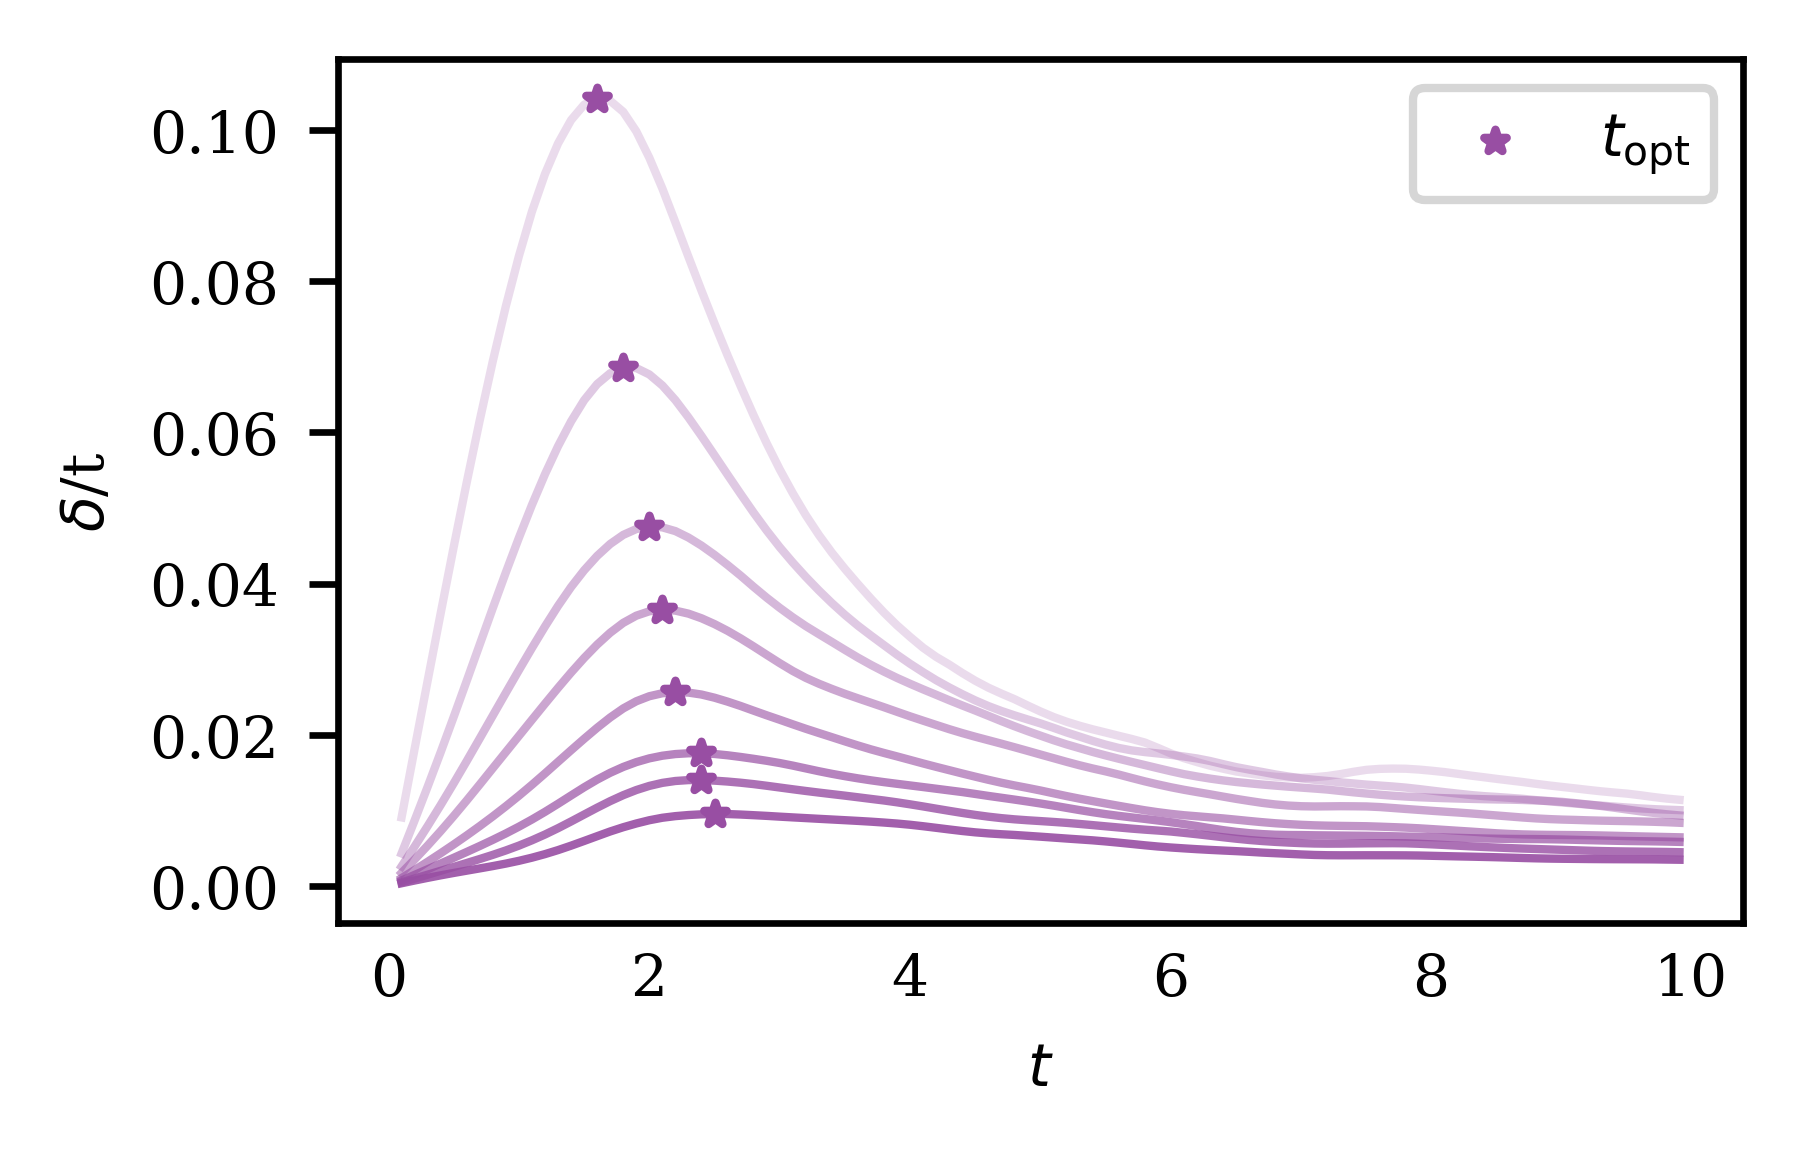

In [138]:
split = 100

fig = plt.figure(figsize=(figure_size_x/2, figure_size_y/2))

for n_id, n in enumerate(qubits_range):
    plt.plot(time_range[1:split], 
            delta_quantum_arr_avg[n_id][1:split] / time_range[1:split],
            color=colors['purple'],
        #     label=f'n={n}',
            alpha=(0.2 + 0.1*n_id))

plt.scatter(t_opt_arr, 
            delta_opt_arr / t_opt_arr, 
            marker='*', 
            c=colors['purple'],
            s=8,
            label='$t_{\mathrm{opt}}$')

plt.xlabel('$t$')
plt.ylabel('$\delta$/t')
plt.legend()
plt.show()
fig.tight_layout()

fig.savefig(projectdir+f'figures/delta_over_t_vs_t')

## Finding optimal $t$

In [139]:
err = time_range[1] - time_range[0]

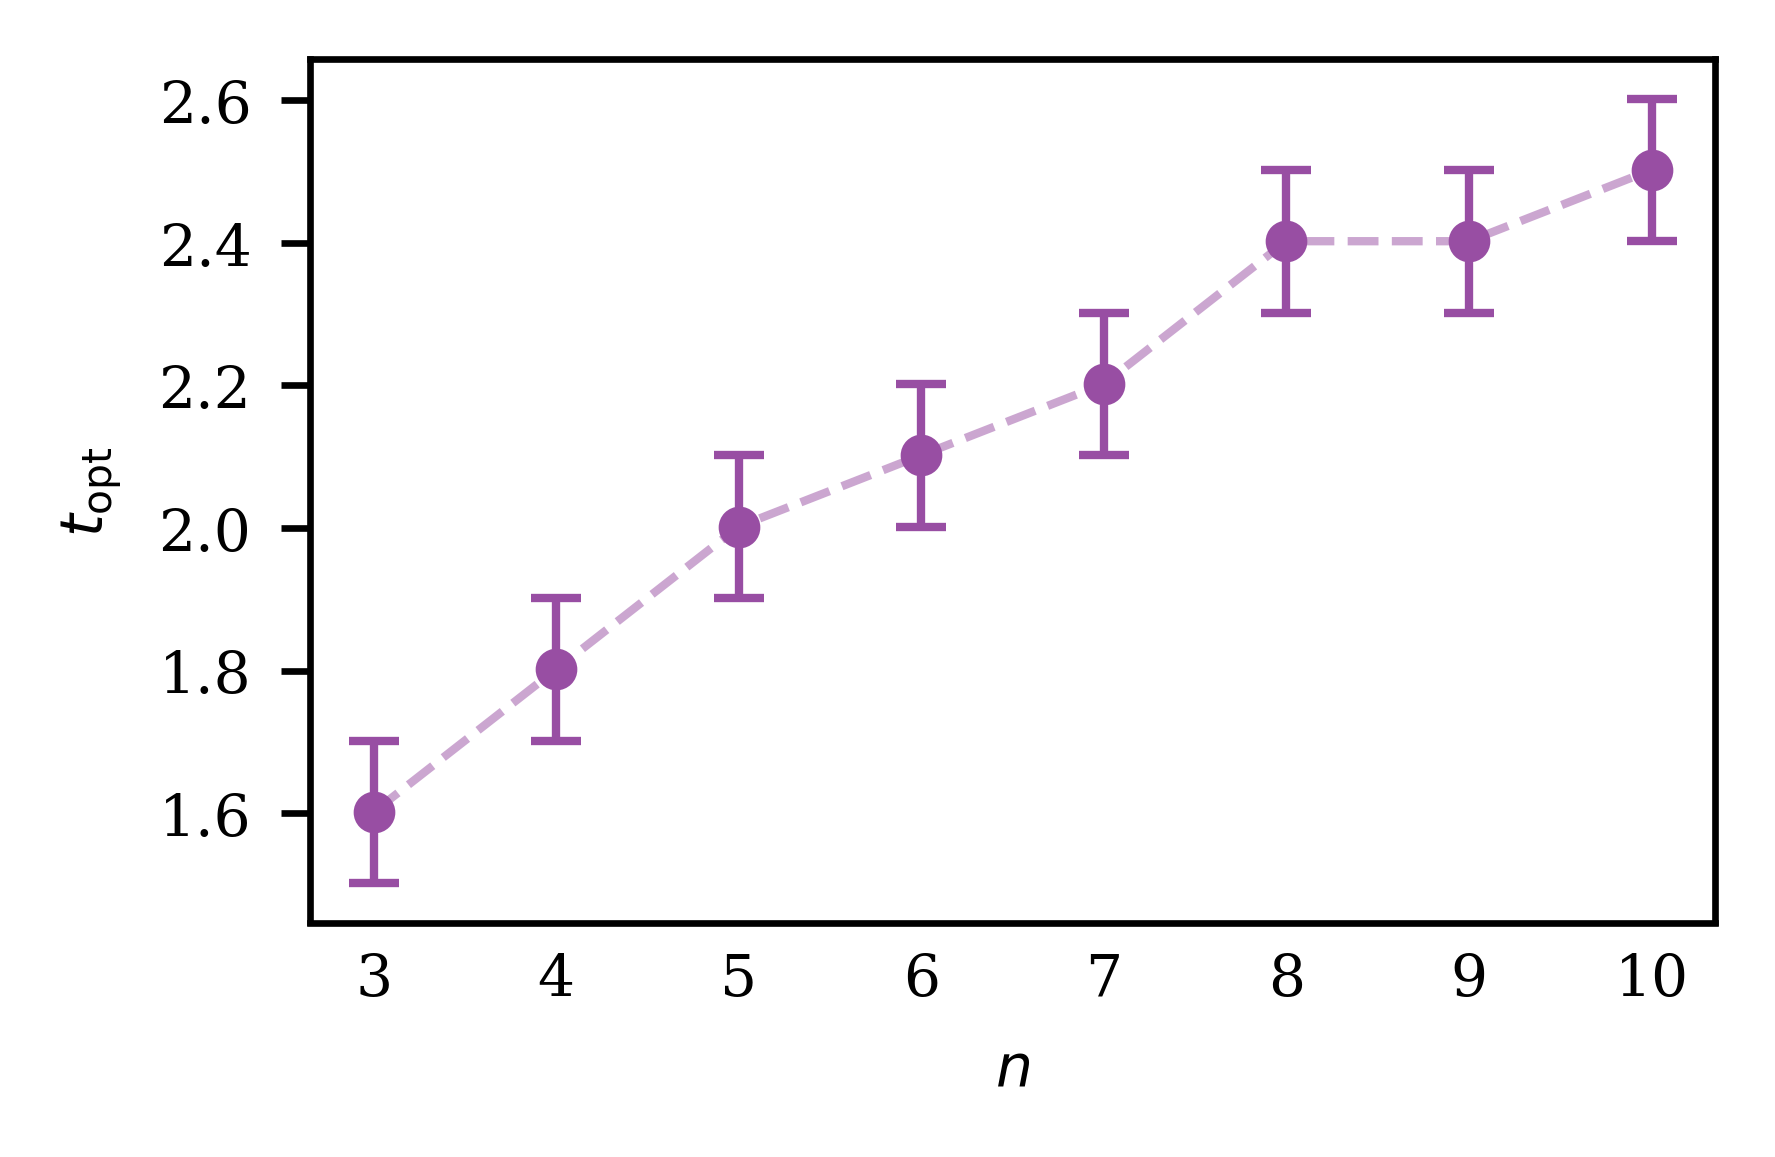

In [144]:
fig = plt.figure(figsize=(figure_size_x/2, figure_size_y/2))

plt.plot(qubits_range, t_opt_arr, '--', color=colors['purple'], alpha=0.5)
plt.errorbar(qubits_range, 
             t_opt_arr, 
             yerr=err, 
             fmt='o', 
             c=colors['purple'],
             ms=4,
             capsize=3)
plt.xlabel('$n$')
plt.ylabel('$t_{\mathrm{opt}}$')
plt.xticks(qubits_range)
plt.show()
fig.tight_layout()

fig.savefig(projectdir+f'figures/t_opt_vs_n')

## Combined panel

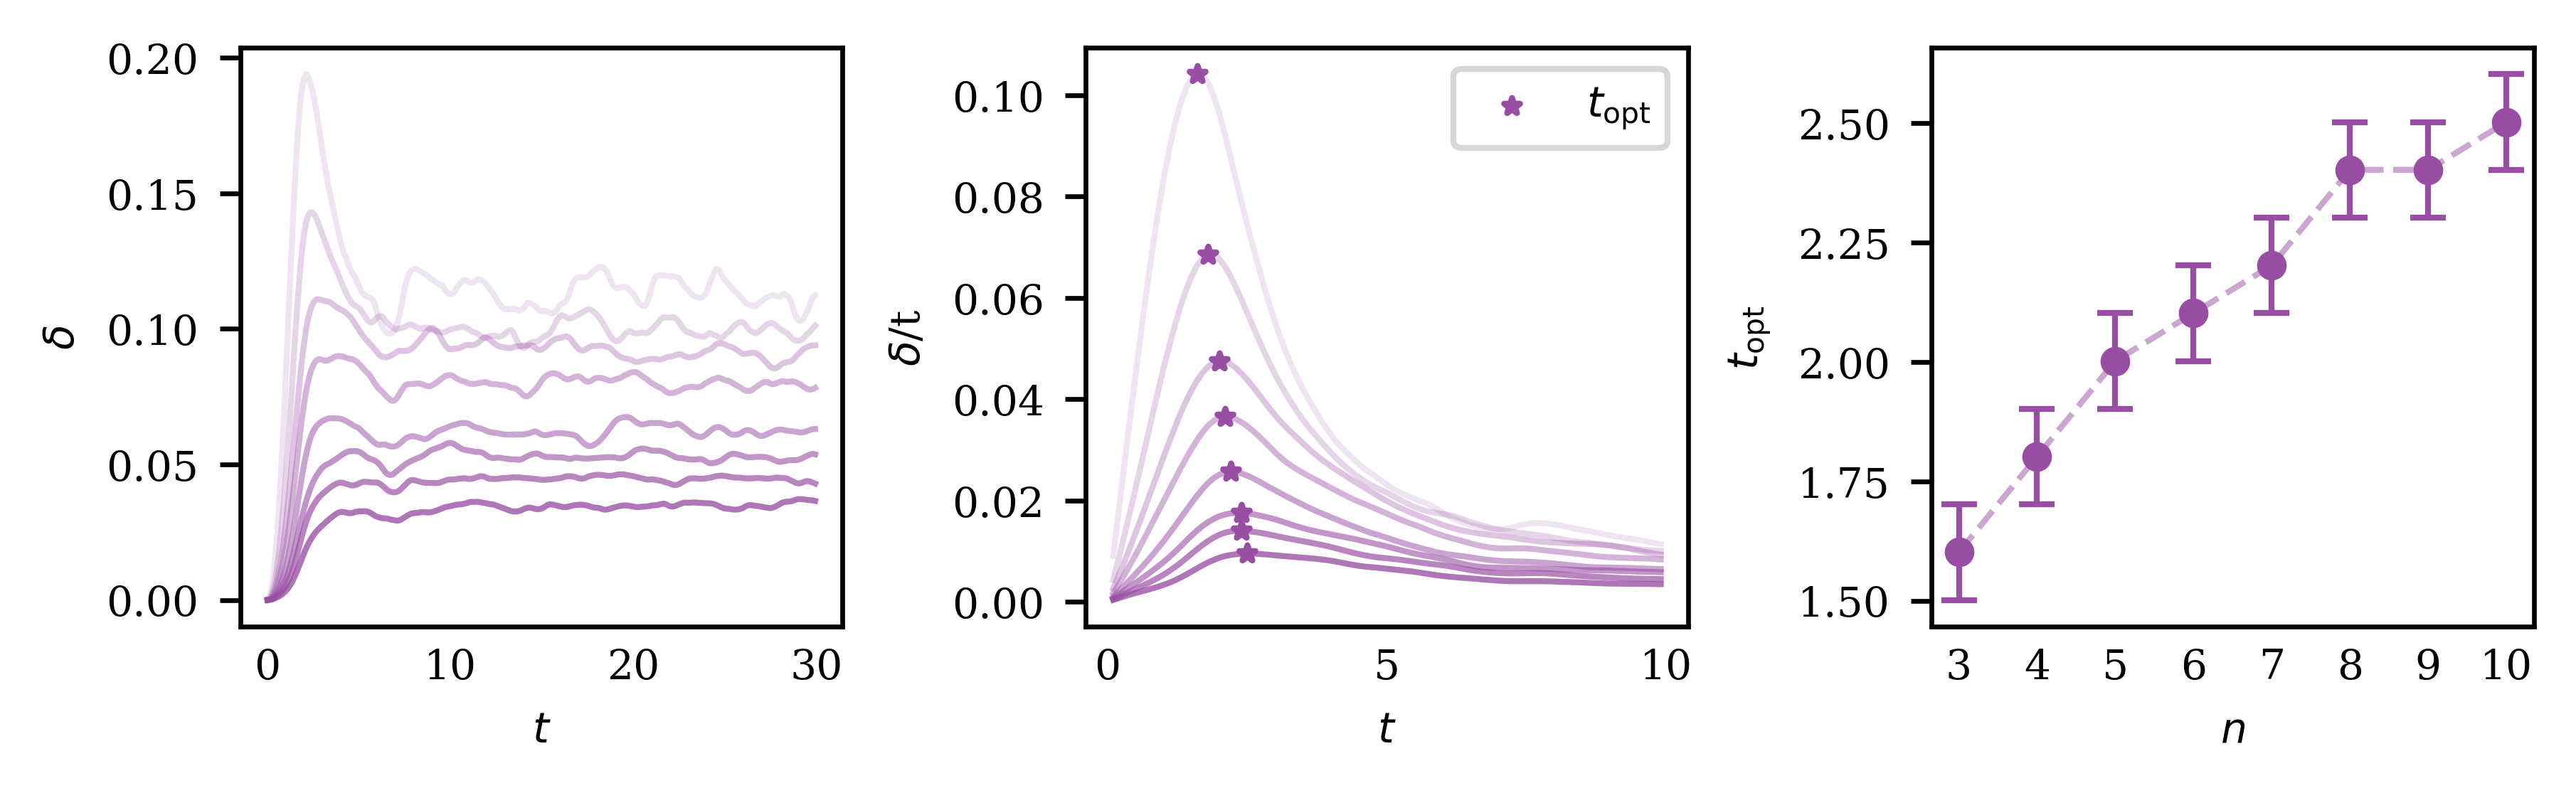

In [148]:
# Set up the 1x3 panel with shared width and height
fig, axes = plt.subplots(1, 3, figsize=(figure_size_x, figure_size_y/2))

# First plot: Delta vs. time
for n_id, n in enumerate(qubits_range):
    axes[0].plot(time_range[:300], 
                 delta_quantum_arr_avg[n_id][:300],
                 color=colors['purple'],
                 label=f'n={n}',
                 alpha=(0.15 + 0.09 * n_id))
axes[0].set_xlabel('$t$')
axes[0].set_ylabel('$\delta$')
# axes[0].legend()  # Uncomment to show legend

# Second plot: Delta over t vs. time with scatter plot
split = 100
for n_id, n in enumerate(qubits_range):
    axes[1].plot(time_range[1:split], 
                 delta_quantum_arr_avg[n_id][1:split] / time_range[1:split],
                 color=colors['purple'],
                 alpha=(0.15 + 0.09 * n_id))
axes[1].scatter(t_opt_arr, 
                delta_opt_arr / t_opt_arr, 
                marker='*', 
                c=colors['purple'],
                s=8,
                label='$t_{\mathrm{opt}}$')
axes[1].set_xlabel('$t$')
axes[1].set_ylabel('$\delta$/t')
axes[1].legend()

# Third plot: t_opt vs. qubit range with error bars
axes[2].plot(qubits_range, t_opt_arr, '--', color=colors['purple'], alpha=0.5)
axes[2].errorbar(qubits_range, 
                 t_opt_arr, 
                 yerr=err, 
                 fmt='o', 
                 c=colors['purple'],
                 ms=4,
                 capsize=3)
axes[2].set_xlabel('$n$')
axes[2].set_ylabel('$t_{\mathrm{opt}}$')
axes[2].set_xticks(qubits_range)

# Adjust layout to avoid overlapping
fig.tight_layout()

# Save the combined figure
fig.savefig(projectdir + 'figures/panel_delta_vs_t')

plt.show()
